# LSTM base net Implemented by Keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

import tensorflow.keras as keras
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

import ipdb
import dan_utils

In [2]:
# 设置随机数种子
seed = 25
dan_utils.setup_seed(seed)

# Load data

In [3]:
flow_df = pd.read_csv('../data/revised_data/flow_y_revised.csv')
flow = flow_df.to_numpy()

In [4]:
flow.shape

(40, 4464)

# Data assembling

In [5]:
# # sliding window
# window_size = 10
# pred_size = 20
# train_X = np.zeros([flow.shape[0] - window_size - pred_size + 1, window_size, flow.shape[1]])
# train_y = np.zeros(train_X.shape[0], pred_size)

# for i in range(window_size):
#     train_X[:, i, :] += flow_df.shift(window_size - i - 1).iloc[window_size - 1:, :]
#     # train_y[:, i] += flow_df.shift(window_size - i - 1).iloc[window_size - 1:, :]


In [6]:
def sliding_window(data, window_size, pred_samp, prop):
    
#     data = data.flatten()
    data_out = []
    label_out = []
    for i in range(data.shape[1] - window_size - pred_samp):
        data_out.append(data[:, i : i + window_size])
        # to predict the next [window size] flows
        label_out.append(data[:, i + window_size + 1: i + window_size + 1 + pred_samp])
    data_out = np.array(data_out)
    label_out = np.array(label_out)
#     ipdb.set_trace()
    train_data_out = data_out[:int(data_out.shape[0]*prop), :]
    train_label_out = label_out[:int(data_out.shape[0]*prop)]
    val_data_out = data_out[int(data_out.shape[0]*prop):, :]
    val_label_out = label_out[int(data_out.shape[0]*prop):]
    
    train_data_out = np.transpose(train_data_out, [0, 2, 1])
    train_label_out = np.transpose(train_label_out, [0, 2, 1])
    val_data_out = np.transpose(val_data_out, [0, 2, 1])
    val_label_out = np.transpose(val_label_out, [0, 2, 1])
    
    return train_data_out, train_label_out, val_data_out, val_label_out


In [114]:
window_size = 10
pred_samp = 6

train_X, train_y, test_X, test_y = sliding_window(flow, window_size, pred_samp, 24/31)
train_X = train_X[-288:, :, :]
train_y = train_y[-288:, :, :]

In [115]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(288, 10, 40)
(288, 6, 40)
(1005, 10, 40)
(1005, 6, 40)


# LSTM network (base)

In [116]:
# data at the position of "number of detectors" are the same
assert train_X.shape[2] == train_y.shape[2]
assert train_X.shape[2] == test_X.shape[2]
assert train_X.shape[2] == test_y.shape[2]
num_det = flow.shape[0]

hid_dim = 40

In [117]:
train_X.shape

(288, 10, 40)

In [118]:
model = keras.models.Sequential()
# out shape: [window_size, hid_dim]
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
model.add(keras.layers.LSTM(units=hid_dim))
model.add(keras.layers.RepeatVector(pred_samp))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(num_det, activation='relu'))

# Training on target data

In [119]:
test_y.shape

(1005, 6, 40)

In [128]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_X, train_y, epochs=500, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=True)

Epoch 1/500
18/18 - 3s - loss: 8148.0010 - val_loss: 8039.3794
Epoch 2/500
18/18 - 0s - loss: 9369.2666 - val_loss: 8165.8906
Epoch 3/500
18/18 - 0s - loss: 10172.4736 - val_loss: 8370.4707
Epoch 4/500
18/18 - 0s - loss: 7733.0068 - val_loss: 8096.6909
Epoch 5/500
18/18 - 0s - loss: 7967.7163 - val_loss: 8527.9473
Epoch 6/500
18/18 - 0s - loss: 10750.5879 - val_loss: 8197.9746
Epoch 7/500
18/18 - 0s - loss: 10806.8525 - val_loss: 7707.7319
Epoch 8/500
18/18 - 0s - loss: 11437.8525 - val_loss: 8937.7031
Epoch 9/500
18/18 - 0s - loss: 7660.1665 - val_loss: 8176.6226
Epoch 10/500
18/18 - 0s - loss: 6811.1641 - val_loss: 7980.3848
Epoch 11/500
18/18 - 0s - loss: 7092.1328 - val_loss: 8305.5244
Epoch 12/500
18/18 - 0s - loss: 8938.6777 - val_loss: 7976.6274
Epoch 13/500
18/18 - 0s - loss: 14459.0215 - val_loss: 8413.9053
Epoch 14/500
18/18 - 0s - loss: 8150.9629 - val_loss: 7987.9492
Epoch 15/500
18/18 - 0s - loss: 9190.0820 - val_loss: 8218.6318
Epoch 16/500
18/18 - 0s - loss: 7234.2446 - 

Epoch 129/500
18/18 - 0s - loss: 6624.8086 - val_loss: 6708.9268
Epoch 130/500
18/18 - 0s - loss: 9909.9199 - val_loss: 6805.9004
Epoch 131/500
18/18 - 0s - loss: 6990.9829 - val_loss: 6883.9883
Epoch 132/500
18/18 - 0s - loss: 7647.1016 - val_loss: 6714.1753
Epoch 133/500
18/18 - 0s - loss: 6947.0234 - val_loss: 6366.1909
Epoch 134/500
18/18 - 0s - loss: 6582.0869 - val_loss: 6651.0171
Epoch 135/500
18/18 - 0s - loss: 6278.1118 - val_loss: 6498.7197
Epoch 136/500
18/18 - 0s - loss: 5640.1240 - val_loss: 6497.3369
Epoch 137/500
18/18 - 0s - loss: 6695.2974 - val_loss: 6480.5869
Epoch 138/500
18/18 - 0s - loss: 6627.6338 - val_loss: 6437.3789
Epoch 139/500
18/18 - 0s - loss: 6682.9038 - val_loss: 7028.4668
Epoch 140/500
18/18 - 0s - loss: 7091.1030 - val_loss: 6743.6216
Epoch 141/500
18/18 - 0s - loss: 7671.9688 - val_loss: 6797.3193
Epoch 142/500
18/18 - 0s - loss: 7234.1709 - val_loss: 8326.7871
Epoch 143/500
18/18 - 0s - loss: 7463.0884 - val_loss: 6951.5991
Epoch 144/500
18/18 - 0s 

Epoch 255/500
18/18 - 0s - loss: 5526.4131 - val_loss: 7167.9961
Epoch 256/500
18/18 - 0s - loss: 9450.0898 - val_loss: 7135.9746
Epoch 257/500
18/18 - 0s - loss: 5246.9092 - val_loss: 6874.1396
Epoch 258/500
18/18 - 0s - loss: 5781.2495 - val_loss: 6635.0508
Epoch 259/500
18/18 - 0s - loss: 5075.0723 - val_loss: 6684.5845
Epoch 260/500
18/18 - 0s - loss: 5107.2358 - val_loss: 6412.3418
Epoch 261/500
18/18 - 0s - loss: 5394.2822 - val_loss: 6538.2271
Epoch 262/500
18/18 - 0s - loss: 6322.7061 - val_loss: 6751.4688
Epoch 263/500
18/18 - 0s - loss: 4957.2026 - val_loss: 6910.3799
Epoch 264/500
18/18 - 0s - loss: 5510.3682 - val_loss: 6749.0986
Epoch 265/500
18/18 - 0s - loss: 5573.2466 - val_loss: 6599.7202
Epoch 266/500
18/18 - 0s - loss: 5723.9756 - val_loss: 6121.8467
Epoch 267/500
18/18 - 0s - loss: 5233.4312 - val_loss: 6453.5791
Epoch 268/500
18/18 - 0s - loss: 5673.2583 - val_loss: 6710.5234
Epoch 269/500
18/18 - 0s - loss: 5283.4531 - val_loss: 6031.8184
Epoch 270/500
18/18 - 0s 

18/18 - 0s - loss: 5041.3687 - val_loss: 6402.6758
Epoch 382/500
18/18 - 0s - loss: 5095.8770 - val_loss: 6347.5645
Epoch 383/500
18/18 - 0s - loss: 6370.6045 - val_loss: 6704.7656
Epoch 384/500
18/18 - 0s - loss: 5683.7583 - val_loss: 6264.8101
Epoch 385/500
18/18 - 0s - loss: 4764.4155 - val_loss: 6291.5601
Epoch 386/500
18/18 - 0s - loss: 5448.3330 - val_loss: 6357.5889
Epoch 387/500
18/18 - 0s - loss: 7445.7246 - val_loss: 6580.6548
Epoch 388/500
18/18 - 0s - loss: 5448.4922 - val_loss: 6704.3281
Epoch 389/500
18/18 - 0s - loss: 4792.2207 - val_loss: 6406.9990
Epoch 390/500
18/18 - 0s - loss: 4763.3965 - val_loss: 6552.6396
Epoch 391/500
18/18 - 0s - loss: 5155.4131 - val_loss: 6467.3735
Epoch 392/500
18/18 - 0s - loss: 4816.3511 - val_loss: 6017.6704
Epoch 393/500
18/18 - 0s - loss: 4622.6362 - val_loss: 6387.3872
Epoch 394/500
18/18 - 0s - loss: 5721.6377 - val_loss: 6013.2832
Epoch 395/500
18/18 - 0s - loss: 5107.7617 - val_loss: 6367.6914
Epoch 396/500
18/18 - 0s - loss: 5550.5

# Visualization

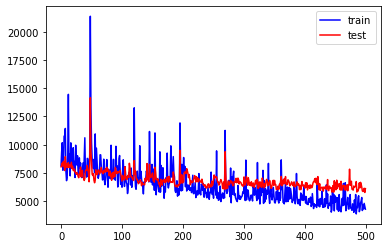

In [129]:
p1 = plt.plot(history.history['loss'], color='blue', label='train')
p2 = plt.plot(history.history['val_loss'], color='red',label='test')
plt.legend()

In [130]:
yhat = model.predict(test_X)

In [131]:
test_y.shape

(1005, 6, 40)

Text(0.5, 1.0, 'Testing dataset')

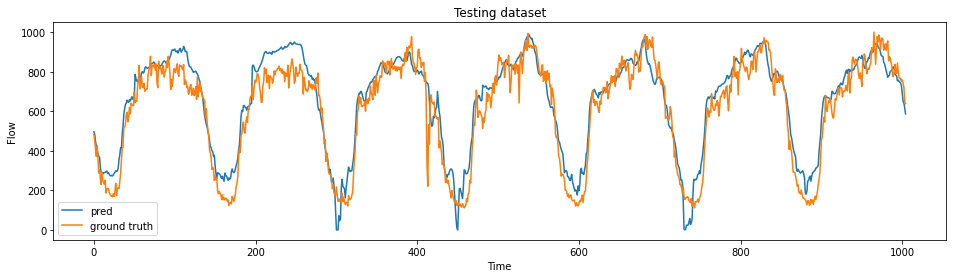

In [135]:
n_step_ahead = 1
det = 0

plt.figure(figsize=[16,4])
plt.plot(yhat[:, n_step_ahead, det], label='pred')
plt.plot(test_y[:, n_step_ahead, det], label='ground truth')
plt.legend()
plt.xlabel('Time')  # time gran: 10 min
plt.ylabel('Flow')
plt.title('Testing dataset')

# Evaluation

In [133]:
#transfer with DAN 预测精度计算
m=0
model_pre = yhat
label_test_target = test_y

nrmse_mean = dan_utils.nrmse_loss_func(model_pre, label_test_target, m)
mape_mean = dan_utils.mape_loss_func(model_pre, label_test_target, m)
smape_mean = dan_utils.smape_loss_func(model_pre, label_test_target, m)
mae_mean = dan_utils.mae_loss_func(model_pre, label_test_target, m)

print('nrmse = ' + str(nrmse_mean) + '\n' + 'mape = ' + str(mape_mean) + '\n' + 'smape = ' + str(smape_mean) + '\n' + 'mae = ' + str(mae_mean))

nrmse = 0.1585740599281183
mape = 0.316159728511463
smape = 0.11293951116209289
mae = 59.37514002136803


In [134]:
# np.save('../res/lstm/2d.npy', model_pre)